### Audio Recognition for Speech Commands dataset

In [ ]:
!pip install pydub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### 1.1 Importing the Speech Commands dataset

In [ ]:
import os
import pathlib
import tensorflow as tf

DATASET_PATH = '/content/drive/MyDrive/Samsung/Audio_Dataset_6'
data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
#Getting the different commands in the dataset
commands = [x for x in os.listdir(DATASET_PATH) if x != 'README.md']
print(f"Commands : {commands}")

Commands : ['Aeroplane', 'Amazon', 'Apple', 'Backpack', 'Bamboo', 'Banana', 'Bike', 'Book', 'Car', 'Cat', 'Chair', 'Clock', 'Coffee', 'Computer', 'Dog', 'Donut', 'Door', 'Electricity', 'Flower', 'Fork', 'Hat', 'Hockey', 'Internet', 'Keys', 'Knife', 'Lamp', 'Moon', 'Netflix', 'Pants', 'Paper', 'Pen', 'Phone', 'Radio', 'Sandals', 'Shark', 'Shirt', 'Shoes', 'Shower', 'Soap', 'Sun', 'Table', 'Television', 'Toothbrush', 'Toothpaste', 'Towel', 'Tree', 'Umbrella', 'Wallet', 'Window', 'Parrot']


In [ ]:
import numpy as np

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
sampling_rate = 48000
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=4,
    validation_split=0.2,
    seed=0,
    output_sequence_length=sampling_rate,
    subset="both"
)

labels = np.array(train_ds.class_names)
print('----------------------------------------------')
print(f'Labels : {labels}')

Found 1000 files belonging to 50 classes.
Using 800 files for training.
Using 200 files for validation.
----------------------------------------------
Labels : ['Aeroplane' 'Amazon' 'Apple' 'Backpack' 'Bamboo' 'Banana' 'Bike' 'Book'
 'Car' 'Cat' 'Chair' 'Clock' 'Coffee' 'Computer' 'Dog' 'Donut' 'Door'
 'Electricity' 'Flower' 'Fork' 'Hat' 'Hockey' 'Internet' 'Keys' 'Knife'
 'Lamp' 'Moon' 'Netflix' 'Pants' 'Paper' 'Parrot' 'Pen' 'Phone' 'Radio'
 'Sandals' 'Shark' 'Shirt' 'Shoes' 'Shower' 'Soap' 'Sun' 'Table'
 'Television' 'Toothbrush' 'Toothpaste' 'Towel' 'Tree' 'Umbrella' 'Wallet'
 'Window']


### 1.2 Preprocess the data

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# Squeezing the extra dimension of channels as there is only one

def squeeze(audio, labels) :
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 48000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
#Splitting the validation set into validation and test sets

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for sample_audio, sample_labels in train_ds.take(1) :
  print(f"Audio Shape : {sample_audio.shape}")
  print(f"Label Shape : {sample_labels.shape}")

Audio Shape : (4, 48000)
Label Shape : (4,)


In [ ]:
from IPython import display
display.display(display.Audio(sample_audio[3], rate=sampling_rate))

### 1.3 Plotting the audio waveforms

In [ ]:
labels[[1, 0, 2, 1]]

array(['Amazon', 'Aeroplane', 'Apple', 'Amazon'], dtype='<U11')

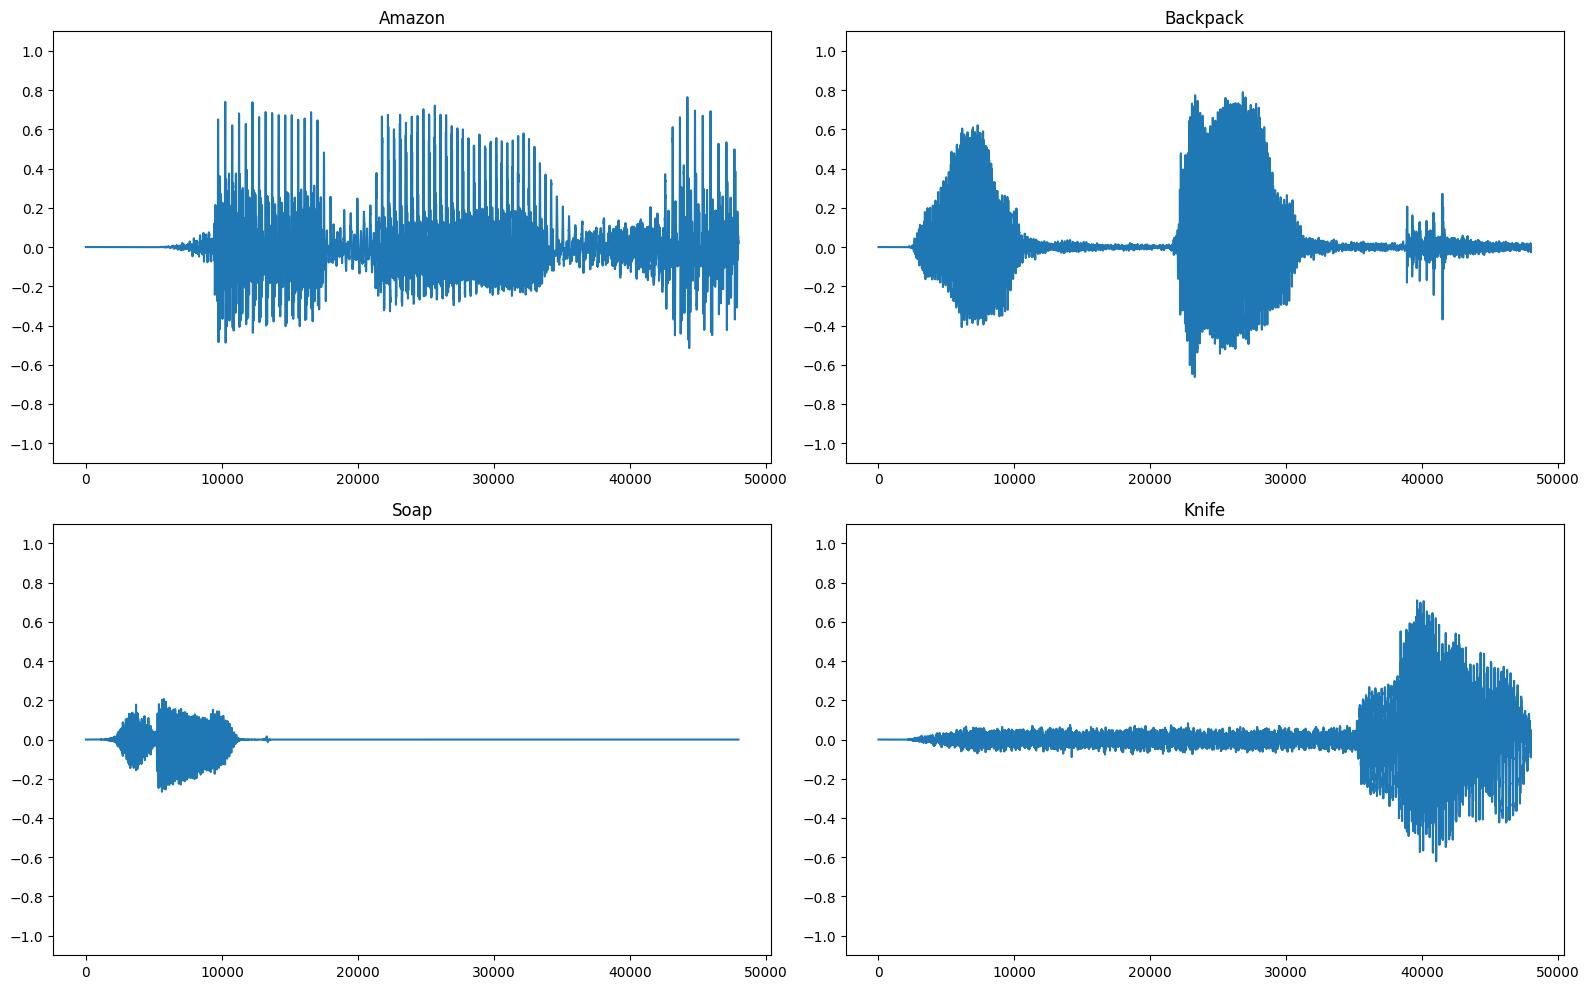

In [ ]:
#Creating a plot with 9 audio samples and corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

rows = 2
cols = 2

for i in range(1, rows * cols + 1) :
  plt.subplot(rows, cols, i)
  audio_sample = sample_audio[i-1]
  audio_label = labels[sample_labels[i-1]]
  plt.plot(audio_sample)
  plt.title(audio_label)
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])
  plt.tight_layout()

### 1.4 Converting the audio data waveforms into spectrograms

In [ ]:
def get_spectrogram(waveform) :
  # 1. Waveform to Spectrogram using Short-time Fourier Transform
  frame_length = int(sampling_rate * 0.025)  # 25 ms frame length
  frame_step = int(sampling_rate * 0.010)   # 10 ms frame step
  spectrogram = tf.signal.stft(waveform,
                              frame_length=frame_length,
                              frame_step=frame_step)

  # 2. Getting the magnitude of Spectrogram
  spectrogram = tf.abs(spectrogram)

  # 3. Adding a new axis to make it look like (batch, samples, channels) form of an image
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:

from IPython import display

for i in range(3) :
  label = sample_labels[i]
  waveform = sample_audio[i]
  spectrogram = get_spectrogram(waveform)

  print(f"Label            : {labels[label]}")
  print(f"Waveform Shape   : {waveform.shape}")
  print(f"Spectrogram Shape : {spectrogram.shape}")
  display.display(display.Audio(waveform, rate=sampling_rate))

Label            : Amazon
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Backpack
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


Label            : Soap
Waveform Shape   : (48000,)
Spectrogram Shape : (98, 1025, 1)


In [ ]:
# Plotting the spectrogram

def plot_spectrogram(spectrogram, ax) :

  # 1. Check if length of spectrogram.shape == 3 else raise an AssertionError and squezze the extra dim
  if(len(spectrogram.shape) > 2) :
    # assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # 2. Do a logarithmic transformation on the spectrogram and add a epsilon to avoid taking log(0)
  log_spec = np.log(spectrogram + np.finfo(float).eps)
  height, width = log_spec.shape[0], log_spec.shape[1]

  # 3. Set X and Y for the colormesh
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

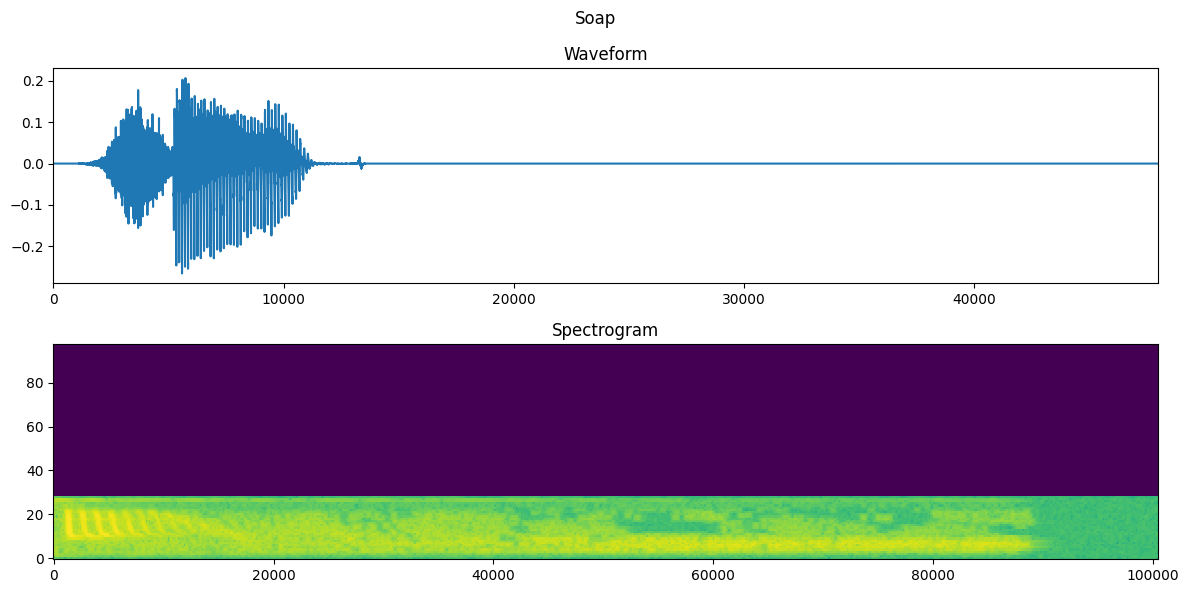

In [ ]:
# Plotting the waveform and spectrogram

fig, axes = plt.subplots(2, figsize=(12, 6))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim(0, sampling_rate)

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(labels[label].title())
plt.tight_layout()
plt.show()

### 1.5 Create Spectrogram datasets from waveform data

In [ ]:
def make_spec_ds(ds) :
  return ds.map(
      map_func = lambda audio, label : (get_spectrogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE
  )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

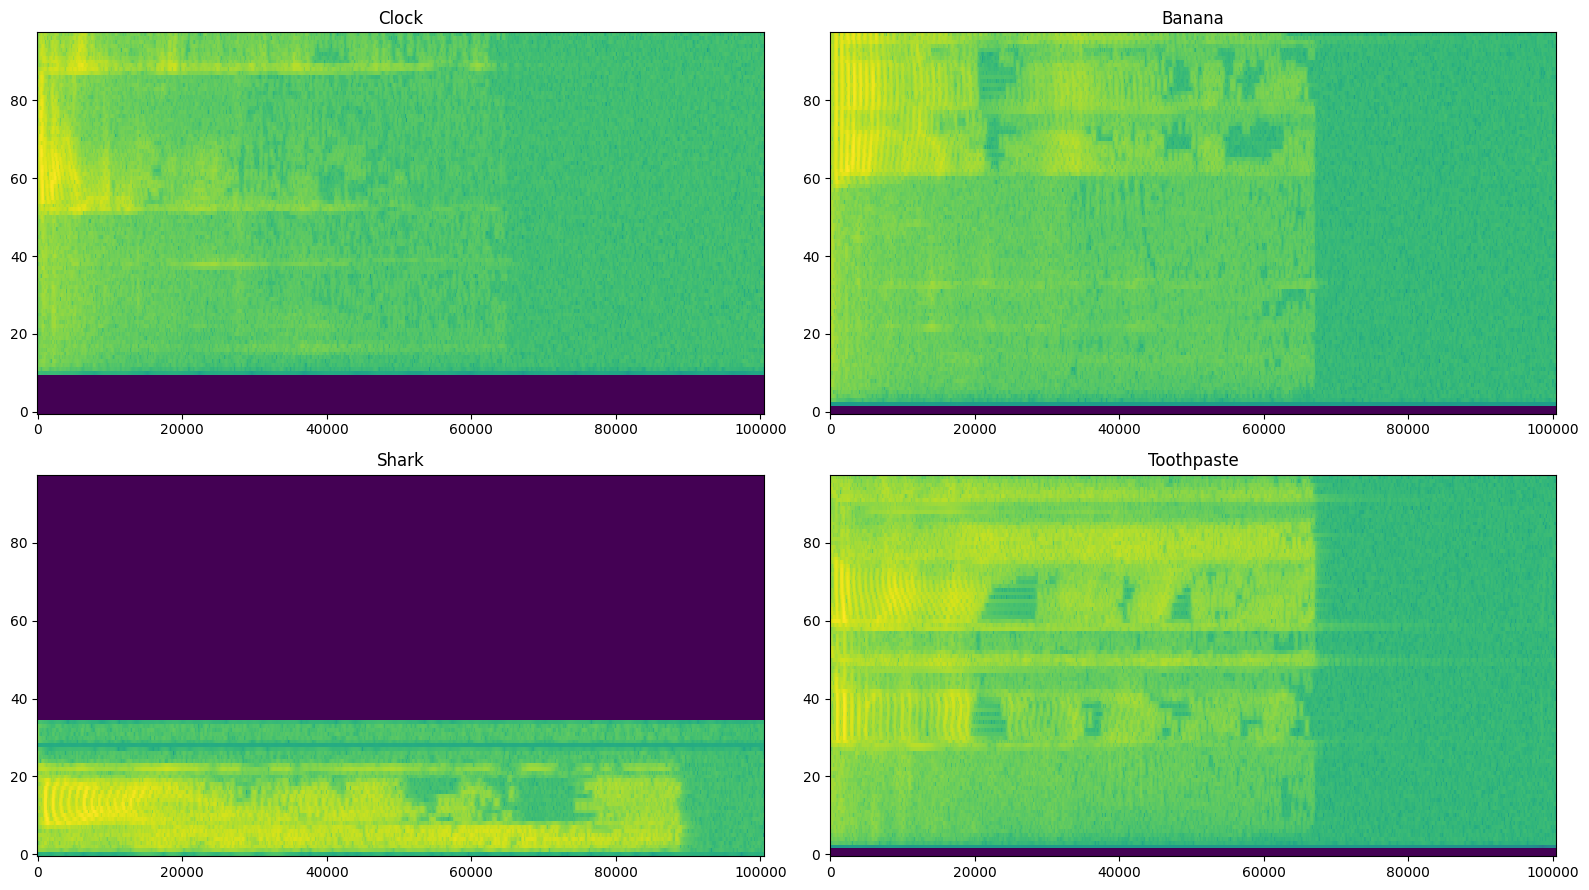

In [ ]:
# Plotting the spectrograms

for sample_spect, sample_spect_labels in train_spectrogram_ds.take(1) :
  break

rows = 2
cols = 2
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n) :
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(sample_spect[i].numpy(), ax)
  ax.set_title(labels[sample_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()

### 2.1 Build and Train the model

In [ ]:
# Add cache and prefetch to reduce latency

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Building a Convolutional Model as audio data is transformed to spectrogram images

input_shape = sample_spect.shape[1:]
print(f"Input Shape : {input_shape}")
num_labels = len(labels)
print(f"Output Units : {num_labels}")


Input Shape : (98, 1025, 1)
Output Units : 50


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model_1 = models.Sequential([
    layers.Input(shape=input_shape[:2]),
    layers.Normalization(axis=-1),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

model_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 98, 1025)          2051      
 on)                                                             
                                                                 
 lstm (LSTM)                 (None, 98, 64)            279040    
                                                                 
 lstm_1 (LSTM)               (None, 98, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 98, 64)            33024     
                                                                 
 lstm_3 (LSTM)               (None, 98, 64)            33024     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                        

In [ ]:
from tensorflow.keras import layers, models

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(
    map_func=lambda spec, label: spec
))

model_1 = models.Sequential([
    layers.Input(shape=input_shape),

    # Downsizing the input for faster input
    layers.Resizing(32, 32),

    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),

    # Add LSTM layers
    layers.Reshape((1, -1)),  # Flatten the output from CNN
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(64),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_1.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 64)       

In [ ]:
# Configuring the model Adam Optimizer and SparseCategoricalCrossentropy

model_1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

In [ ]:
# Training the model for 30 epochs

EPOCHS = 30

history = model_1.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = EPOCHS
)

Epoch 1/30
200/200 [==============================] - 22s 110ms/step - loss: 1.8985 - accuracy: 0.4437 - val_loss: 3.1594 - val_accuracy: 0.3400
Epoch 2/30
200/200 [==============================] - 22s 112ms/step - loss: 1.6934 - accuracy: 0.4975 - val_loss: 3.2887 - val_accuracy: 0.3600
Epoch 3/30
200/200 [==============================] - 18s 92ms/step - loss: 1.5148 - accuracy: 0.5487 - val_loss: 3.3201 - val_accuracy: 0.4000
Epoch 4/30
200/200 [==============================] - 19s 96ms/step - loss: 1.3496 - accuracy: 0.6012 - val_loss: 3.4135 - val_accuracy: 0.4100
Epoch 5/30
200/200 [==============================] - 19s 95ms/step - loss: 1.2423 - accuracy: 0.6538 - val_loss: 3.5560 - val_accuracy: 0.4000
Epoch 6/30
200/200 [==============================] - 21s 107ms/step - loss: 1.1585 - accuracy: 0.6575 - val_loss: 3.7425 - val_accuracy: 0.4100
Epoch 7/30
200/200 [==============================] - 20s 98ms/step - loss: 1.0428 - accuracy: 0.6875 - val_loss: 3.8322 - val_accura

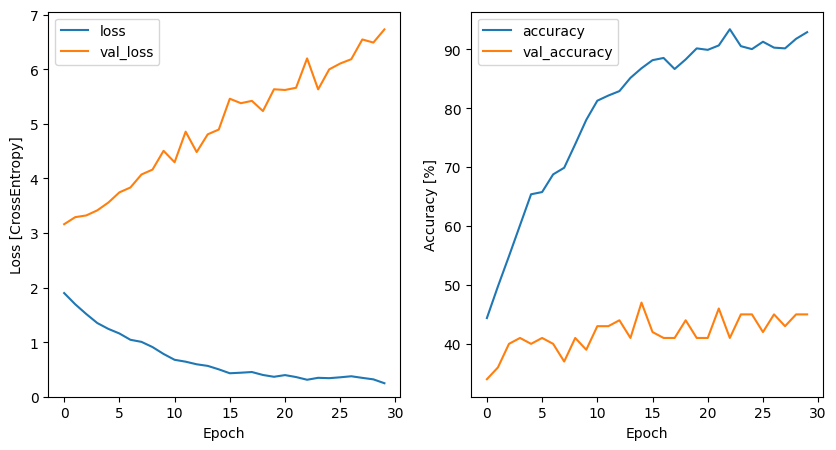

In [ ]:
#Plotting the Loss and Accuracy Curves

metrics = history.history

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylim(0, max(plt.ylim()))
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

### 3.1 Evaluate the model performance

In [ ]:
model_1.evaluate(test_spectrogram_ds, return_dict=True)

25/25 [==============================] - 0s 12ms/step - loss: 5.4066 - accuracy: 0.4300


{'loss': 5.4065985679626465, 'accuracy': 0.4300000071525574}

### 3.2 Display a Confusion Matrix

In [ ]:
y_pred = tf.argmax(model_1.predict(test_spectrogram_ds), axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, label : label)), axis=0)

25/25 [==============================] - 0s 12ms/step


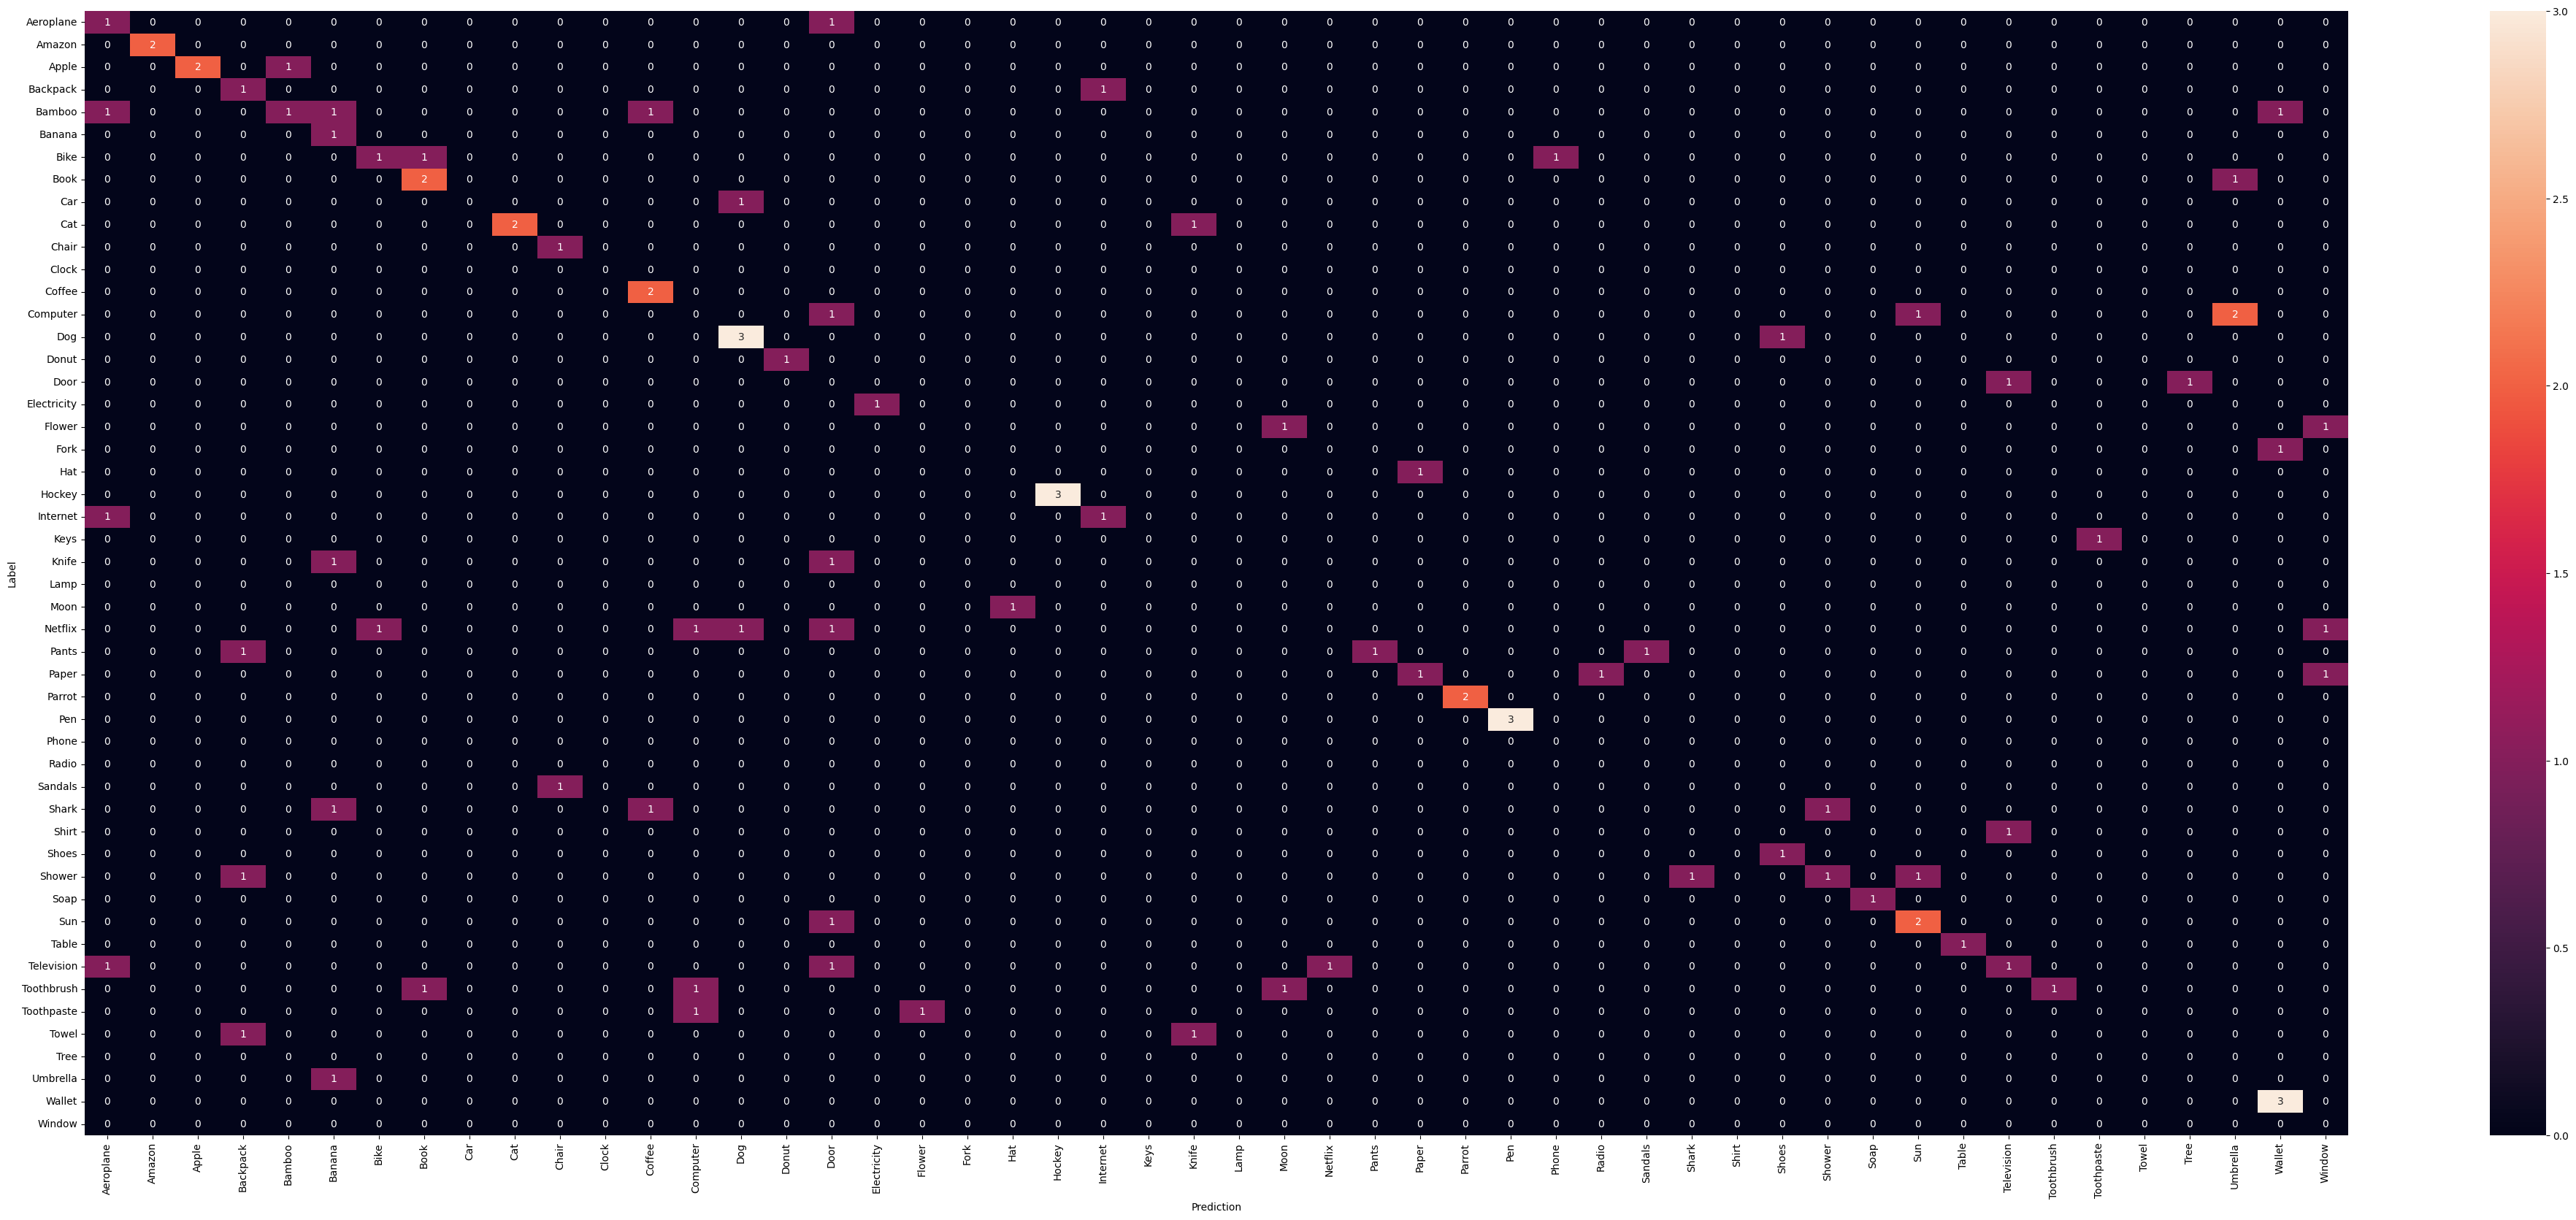

In [ ]:
import seaborn as sns

conf_mat = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(50, 20))
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### 3.3 Run inference on random audio file

In [ ]:
data_dir

PosixPath('/content/drive/MyDrive/Samsung/Audio_Dataset_6')

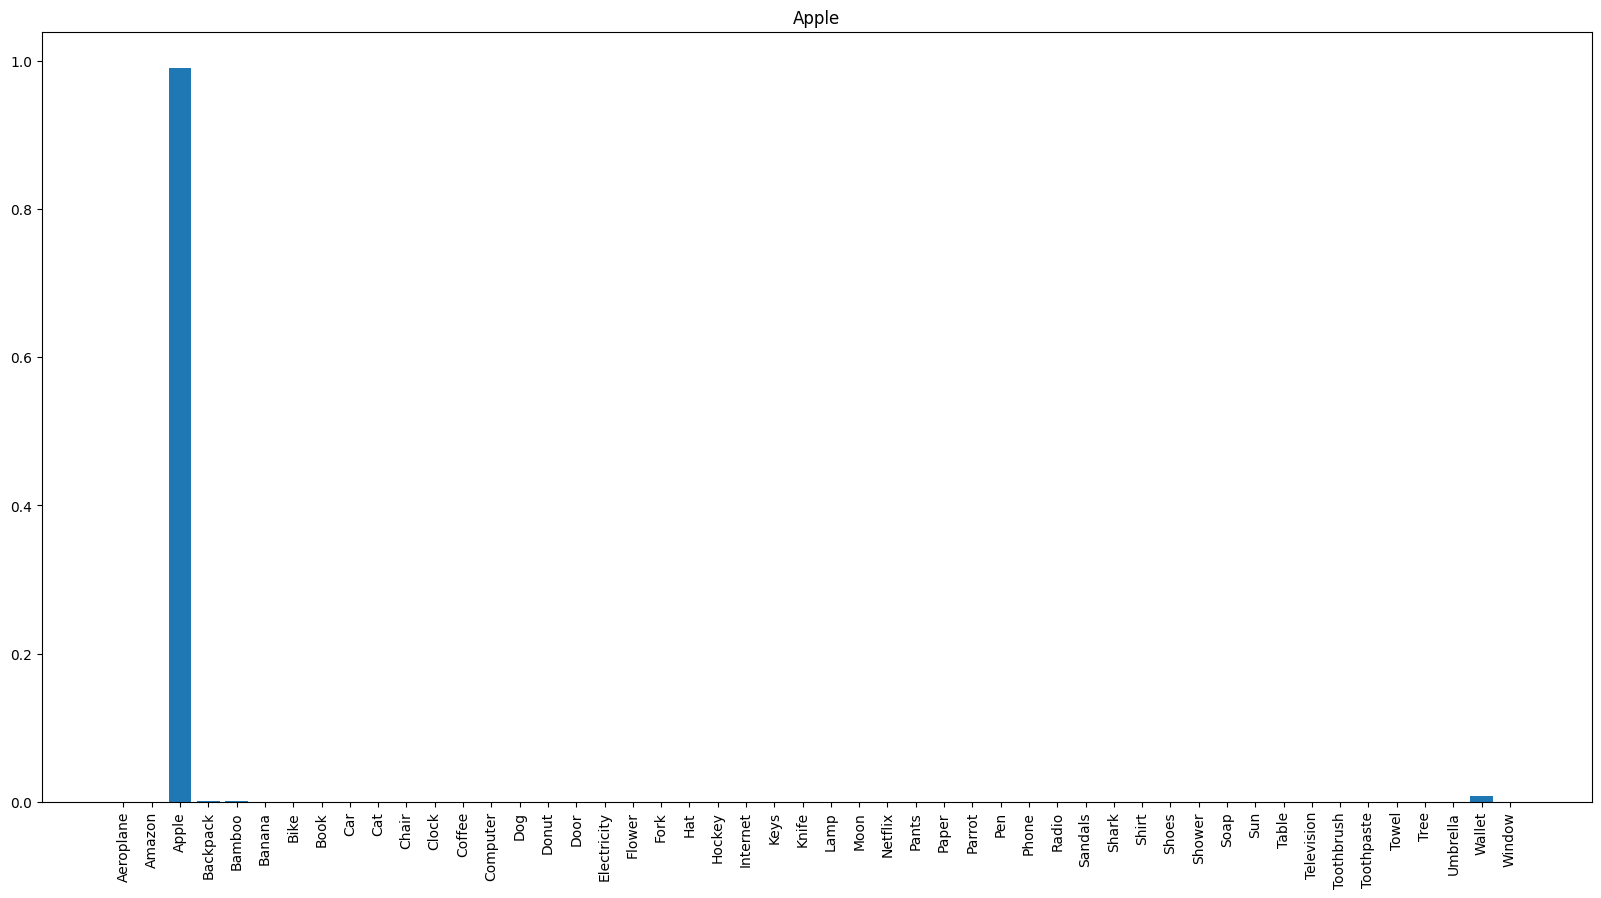

In [ ]:
x = data_dir/'Apple'/'Apple_0015.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sampling_rate)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]
pred = model_1(x)
plt.figure(figsize=(20, 10))
plt.bar(labels, tf.nn.softmax(pred[0]))
plt.title('Apple')
plt.xticks(rotation='vertical')
plt.show()

display.display(display.Audio(waveform, rate=sampling_rate))

### 4. Export the model with preprocessing steps


In [ ]:
class ExportModel(tf.Module) :
  def __init__(self, model) :

    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string),
    )
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, sampling_rate], dtype=tf.float32)
    )

  @tf.function
  def __call__(self, x) :
    if x.dtype == tf.string :
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=sampling_rate,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, ...]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(labels, class_ids)
    return {
        'predictions' : result,
        'class_ids' : class_ids,
        'class_names' : class_names
    }


In [ ]:
# Test run the export model

export = ExportModel(model_1)
export(tf.constant(str(data_dir/'Apple/Apple_0002.wav')))

{'predictions': <tf.Tensor: shape=(1, 50), dtype=float32, numpy=
 array([[-21.633522 , -10.736225 ,   1.4697404,  -9.09997  ,  -2.7035627,
          -6.8177347, -31.847971 , -30.412197 , -21.951586 , -19.814753 ,
         -25.636211 , -29.502    , -17.57249  , -16.837618 , -21.501345 ,
          -9.70472  , -15.495139 , -30.768986 , -19.878986 , -37.014122 ,
         -16.105896 , -16.42539  , -14.895709 , -37.37112  , -35.04241  ,
         -19.354681 , -32.852215 , -21.740332 , -34.75358  , -20.727468 ,
          -8.632338 , -25.075886 , -32.523655 , -14.680989 , -33.184986 ,
         -10.192166 , -29.005676 , -28.9246   , -12.40347  , -31.526247 ,
         -35.69805  , -24.47807  , -26.96278  , -31.820671 , -26.485888 ,
          -7.7091846, -31.81913  , -14.896612 ,  -6.1608515, -27.743229 ]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([2])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Apple'], dtype=object)>}

In [ ]:
# Save and reload the model

tf.saved_model.save(export, 'saved')
reloaded_model = tf.saved_model.load('saved')


In [ ]:
print(reloaded_model(waveform[tf.newaxis, :]))

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([45])>, 'predictions': <tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[-22.871338 , -22.133228 ,  -9.107705 , -10.776648 ,  -9.9302225,
         -7.8912306, -31.41501  , -24.989061 , -24.351297 , -15.548992 ,
        -24.278517 , -21.186243 , -14.359189 , -15.535596 , -20.977276 ,
        -22.951067 ,  -6.124223 , -33.068886 , -12.550163 , -28.794712 ,
        -23.29626  , -22.766417 , -25.65809  , -35.704227 , -35.545563 ,
        -13.404116 , -21.840883 , -24.871853 , -35.125046 , -22.439064 ,
        -11.769732 , -21.635155 , -25.451948 , -15.232606 , -35.538475 ,
        -16.162563 , -33.710537 , -28.762762 , -15.378385 , -26.76829  ,
        -26.484186 , -32.98344  , -35.806957 , -20.966253 , -20.887447 ,
         -5.19666  , -24.968096 ,  -8.58443  , -12.91216  , -23.85466  ]],
      dtype=float32)>, 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Towel'], dtype=object)>}
